Ziyue Gong

joy.gong@mail.utoronto.ca

1005710740


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
apartment_for_rent_classified = fetch_ucirepo(id=555)

# data (as pandas dataframes)
X_full = apartment_for_rent_classified.data.features
y_full = apartment_for_rent_classified.data.targets

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
for col in X_full.columns:
    print(col)

print(len(X_full))

category
title
body
amenities
bathrooms
bedrooms
currency
fee
has_photo
pets_allowed
price
price_display
price_type
square_feet
address
cityname
state
latitude
longitude
source
time
99826


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_feature_distributions(
    df: pd.DataFrame,
    max_cats: int = 20,      # show top-N categories; group the rest as "Other"
    bins: int = 30,          # bins for numeric histograms
    figsize_per_plot=(4, 3), # width, height per subplot
    dropna_label: str = "NaN"
):
    ncols = 3  # columns in the subplot grid
    n = len(df.columns)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, col in enumerate(df.columns):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        s = df[col]

        # Decide type: numeric vs categorical-like
        is_num = pd.api.types.is_numeric_dtype(s)
        if not is_num:
            # try to coerce numeric strings
            s_num = pd.to_numeric(s.astype(str).str.replace(",", ""), errors="coerce")
            if s_num.notna().sum() > 0 and s_num.notna().sum() >= 0.9 * s.notna().sum():
                # mostly numeric-as-string → treat as numeric
                s = s_num
                is_num = True

        if is_num:
            # numeric histogram
            s_clean = s.dropna()
            ax.hist(s_clean.values, bins=bins)
            ax.set_title(f"{col}\n(n={s_clean.size})")
            ax.set_xlabel("")
            ax.set_ylabel("count")
        else:
            # categorical bar: top-N, group rest as Other
            vc = s.fillna(dropna_label).astype(str).value_counts()
            if len(vc) > max_cats:
                top = vc.iloc[:max_cats].copy()
                top["Other"] = vc.iloc[max_cats:].sum()
                vc = top
            ax.bar(vc.index.astype(str), vc.values)
            ax.set_title(f"{col} (k={len(vc)})")
            ax.set_xlabel("")
            ax.set_ylabel("count")
            # rotate labels for readability
            ax.tick_params(axis='x', labelrotation=60)

        # tight layout per-axes
        ax.grid(False)

    # hide any empty subplots
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    fig.tight_layout()
    plt.show()

### filter to Dallas

Rows in TX: 11279


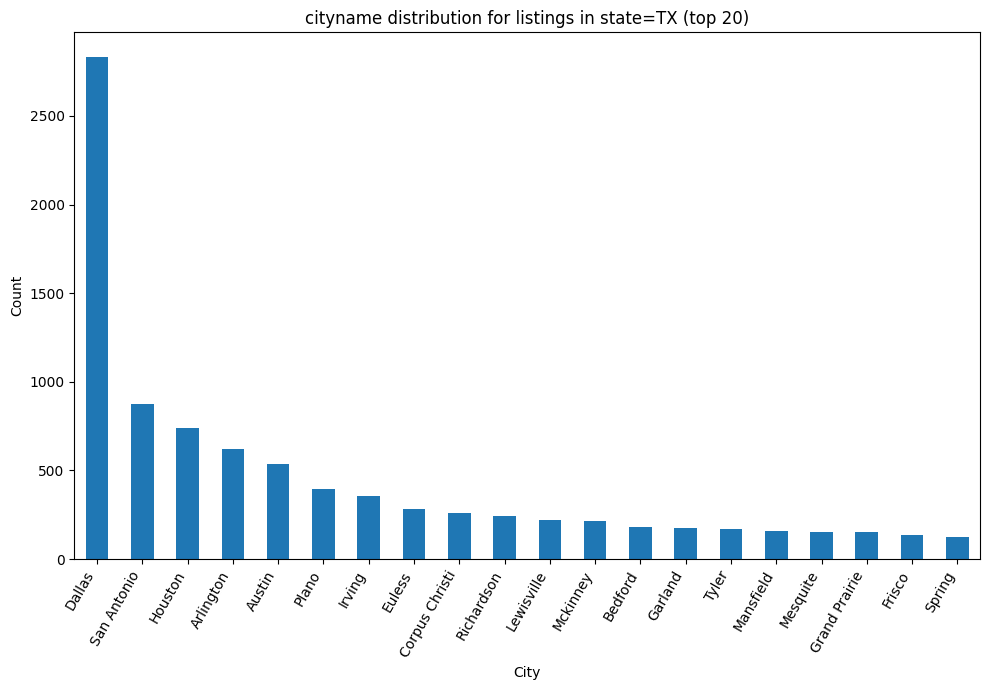

                count  percentage
cityname                         
Dallas           2830       25.09
San Antonio       873        7.74
Houston           740        6.56
Arlington         622        5.51
Austin            535        4.74
Plano             394        3.49
Irving            357        3.17
Euless            285        2.53
Corpus Christi    258        2.29
Richardson        245        2.17
Lewisville        221        1.96
Mckinney          217        1.92
Bedford           182        1.61
Garland           177        1.57
Tyler             169        1.50
Mansfield         157        1.39
Mesquite          154        1.37
Grand Prairie     151        1.34
Frisco            133        1.18
Spring            127        1.13


In [ ]:
# ---- pick column names (adjust if your columns are different) ------------
state_col_candidates = [c for c in X_full.columns if c.lower() in ("state","state_name","region")]
city_col_candidates  = [c for c in X_full.columns if c.lower() in ("city","cityname","city_name")]

assert len(state_col_candidates) > 0, "Couldn't find a state column in X."
assert len(city_col_candidates)  > 0, "Couldn't find a city column in X."

state_col = state_col_candidates[0]
city_col  = city_col_candidates[0]

# ---- filter to Texas ------------------------------------------------------
df_tx = X_full[X_full[state_col].astype(str).str.upper() == "TX"].copy()
print(f"Rows in TX: {len(df_tx)}")

# ---- city counts (clean minor whitespace) --------------------------------
city_counts = (
    df_tx[city_col].astype(str).str.strip().replace({"": "Unknown"}).value_counts()
)

# Show top-N cities (change N as you like)
N = 20
top_counts = city_counts.head(N)

# ---- plot -----------------------------------------------------------------
plt.figure(figsize=(10, max(4, 0.35*len(top_counts))))
top_counts.plot(kind="bar")
plt.title(f"cityname distribution for listings in state=TX (top {N})")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# (Optional) also print a small table with counts and percentages
out = (top_counts.to_frame("count")
       .assign(percentage=lambda d: (d["count"] / city_counts.sum()*100).round(2)))
print(out)

### select features

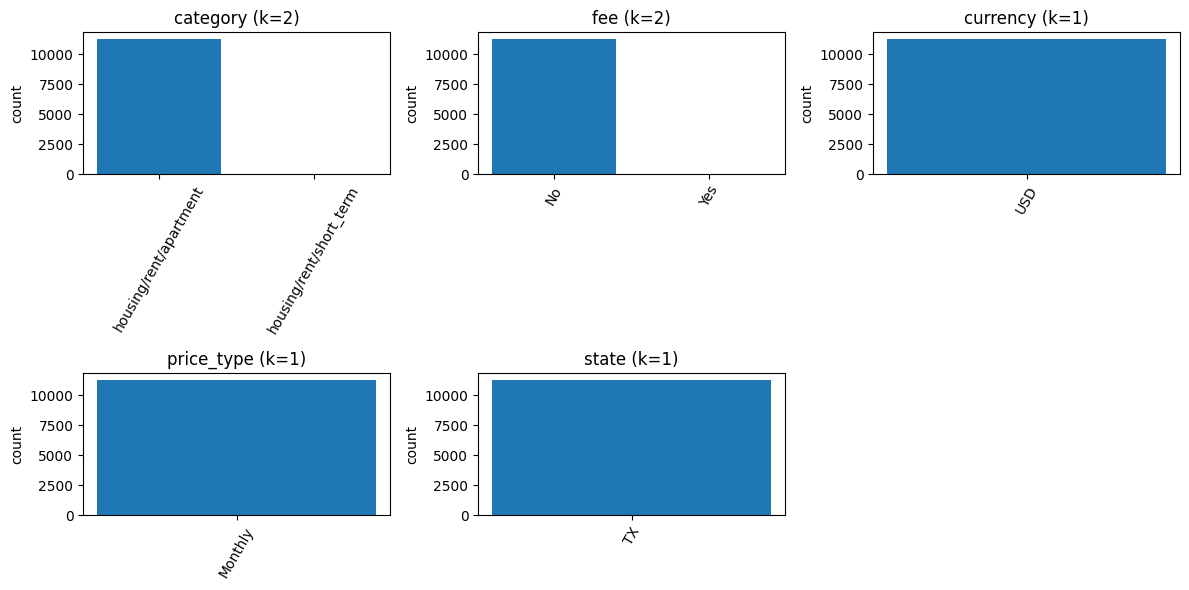

In [ ]:
plot_feature_distributions(df_tx[["category", "fee", "currency", "price_type", "state"]])

### explore selected features

In [ ]:
selected_features = [
    'amenities',
    'bathrooms',
    'bedrooms',
    'price', # target, numerical
    'square_feet',
    'has_photo',
    'pets_allowed'
]

X = X_full[X_full['cityname'].astype(str).str.strip().str.casefold() == 'dallas'][selected_features]

In [ ]:
missing_counts = X[selected_features].isna().sum()

# Print result
print(missing_counts)

amenities        546
bathrooms          1
bedrooms           3
price              0
square_feet        0
has_photo          0
pets_allowed    1873
dtype: int64


In [ ]:
def print_unique_value_counts(df, column_name):
    """
    Prints each unique value in a column and its count, including NaNs.
    """
    value_counts = df[column_name].value_counts(dropna=False)
    for i, (value, count) in enumerate(value_counts.items(), 1):
        print(f"{i}. {value}: {count}")

In [ ]:
print_unique_value_counts(X, 'has_photo')
print_unique_value_counts(X, 'pets_allowed')

1. Yes: 1762
2. Thumbnail: 732
3. No: 368
1. nan: 1873
2. Cats,Dogs: 965
3. Cats: 22
4. Dogs: 2


### dtype
- numerical: bathrooms, bedrooms, square_feet
- categorical: amenities, has_photo, pets_allowed (first turn nan to not allowed)

### square_feet

In [ ]:
X['square_feet']  = pd.to_numeric(X['square_feet'], errors='coerce')

### bathroom & bedroom

In [ ]:
X = X.dropna(subset=[
    'bathrooms',
    'bedrooms',
])

In [ ]:
X['bathrooms'] = pd.to_numeric(X['bathrooms'], errors='coerce')
X['bedrooms']  = pd.to_numeric(X['bedrooms'], errors='coerce')

### amenities

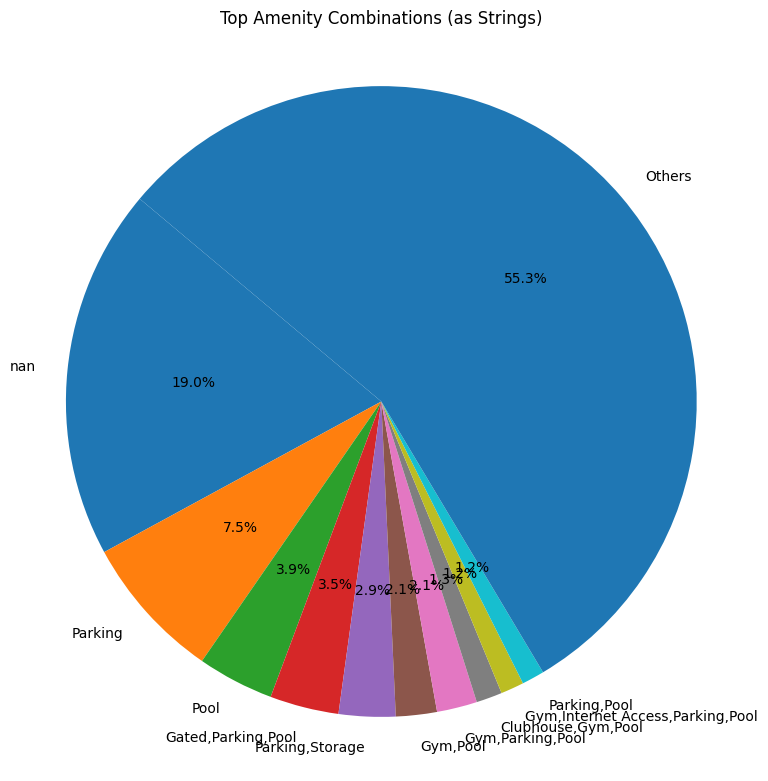

In [ ]:
# Get counts of unique amenity combinations
amenity_counts = X['amenities'].value_counts(dropna=False)

# Optional: show only top N most frequent combinations
top_n = 10
amenity_counts_top = amenity_counts[:top_n]
others_count = amenity_counts[top_n:].sum()
amenity_counts_top["Others"] = others_count

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(amenity_counts_top, labels=amenity_counts_top.index, autopct='%1.1f%%', startangle=140)
plt.title("Top Amenity Combinations (as Strings)")
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# --- parameters ---
threshold = 50  # keep amenities that appear in at least 50 listings

# 1) missing flag (so model can learn 'not specified')
X['amenities_missing'] = X['amenities'].isna().astype(int)

# 2) parse comma-separated strings → list of amenities
amenity_lists = (
    X['amenities']
    .fillna('')                                  # NaN -> ''
    .map(lambda s: [a.strip() for a in s.split(',') if a.strip()])
)

# 3) multi-label binarize
mlb = MultiLabelBinarizer()
amenities_bin = mlb.fit_transform(amenity_lists)
amenities_df = pd.DataFrame(amenities_bin, columns=mlb.classes_, index=X.index)

# 4) keep only frequent amenities (>= threshold)
keep_cols = amenities_df.columns[amenities_df.sum(axis=0) >= threshold]
amenities_df = amenities_df[keep_cols]

# 5) merge back and drop original text column
X = pd.concat([X.drop(columns=['amenities']), amenities_df], axis=1)

### has_photo

In [ ]:
# One-hot (keeps 3 binary columns; includes NaN as its own level if any)
# creates columns like: has_photo_Yes, has_photo_Thumbnail, has_photo_No (and has_photo_NaN if present).
has_photo_ohe = pd.get_dummies(X['has_photo'].fillna('NaN'), prefix='has_photo', dtype='uint8')

# Replace original column with encoded columns
X = pd.concat([X.drop(columns=['has_photo']), has_photo_ohe], axis=1)

### pets_allowed

In [ ]:
s = X['pets_allowed'].replace(r'^\s*$', pd.NA, regex=True)
X['pets_allowed_allow'] = s.notna().astype(int)
# non-NaN entry as 1 (allows), and NaNs (or blanks) as 0 (not allowed).

In [ ]:
X.drop(columns=['pets_allowed'], inplace=True)

### verify dtype and no nan

In [ ]:
# print col dtype and no nan counts
for col in X.columns:
    print(col, X[col].dtype, X[col].isna().sum())

bathrooms float64 0
bedrooms float64 0
price float64 0
square_feet float64 0
amenities_missing int64 0
AC int64 0
Basketball int64 0
Cable or Satellite int64 0
Clubhouse int64 0
Dishwasher int64 0
Elevator int64 0
Fireplace int64 0
Garbage Disposal int64 0
Gated int64 0
Gym int64 0
Hot Tub int64 0
Internet Access int64 0
Parking int64 0
Patio/Deck int64 0
Playground int64 0
Pool int64 0
Refrigerator int64 0
Storage int64 0
TV int64 0
Washer Dryer int64 0
Wood Floors int64 0
has_photo_No uint8 0
has_photo_Thumbnail uint8 0
has_photo_Yes uint8 0
pets_allowed_allow int64 0


## model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer

In [ ]:
X_num = X.drop(columns=['price']).copy()
y = X['price'].astype(float)

In [ ]:
print(X_num.shape)
print(y.shape)

(2858, 29)
(2858,)


In [ ]:
Xtr, Xte, ytr, yte = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)

### linear baseline

In [ ]:
# linear baseline
lin = Pipeline([
    ('sc', StandardScaler()), # feature scaling
    ('enet', ElasticNet(alpha=0.1, # overall regularization strength (↑alpha => more shrinkage; alpha=0 ≈ OLS)
                        l1_ratio=0.5, # 0=ridge (all L2), 1=lasso (all L1);, between 0–1 = ElasticNet mix (higher => more sparsity)
                        max_iter=1000))
])

lin.fit(Xtr, ytr)
pred_log = lin.predict(Xte)

# back to price for metrics/plots
y_true = np.expm1(yte)
pred   = np.expm1(pred_log)

mse = mean_squared_error(y_true, pred)
print(f"ElasticNet  MSE: {mse:.2f}")

ElasticNet  MSE: 17464.49


#### tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

def mse_price(y_true, y_pred):
    return mean_squared_error(np.expm1(y_true), np.expm1(y_pred)) # back to price

mse_scorer = make_scorer(mse_price, greater_is_better=False) # lower mse, better

cv = KFold(n_splits=5, shuffle=True, random_state=42)


# base
lin = Pipeline([
    ('sc', StandardScaler()),
    ('enet', ElasticNet(max_iter=5000))
])

# search grid on train
param_grid = {
    'enet__alpha': np.logspace(-3, 1, 10),
    'enet__l1_ratio': [0.1, 0.5, 0.9],
}

grid = GridSearchCV(
    lin,
    param_grid=param_grid,
    scoring=mse_scorer,           # minimize price-MSE
    cv=cv,
    n_jobs=-1, # parallel run
    return_train_score=False,
    verbose=0
)

grid.fit(Xtr, ytr)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('enet', ElasticNet(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'enet__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
                         'enet__l1_ratio': [0.1, 0.5, 0.9]},
             scoring=make_scorer(mse_price, greater_is_better=False, response_method='predict'))

##### print best


Best params: {'enet__alpha': np.float64(0.05994842503189409), 'enet__l1_ratio': 0.9}
Best CV MSE (price units): 18398.60

Test — MSE: 17650.95 |  MAE: 109.08 | R²: 0.938


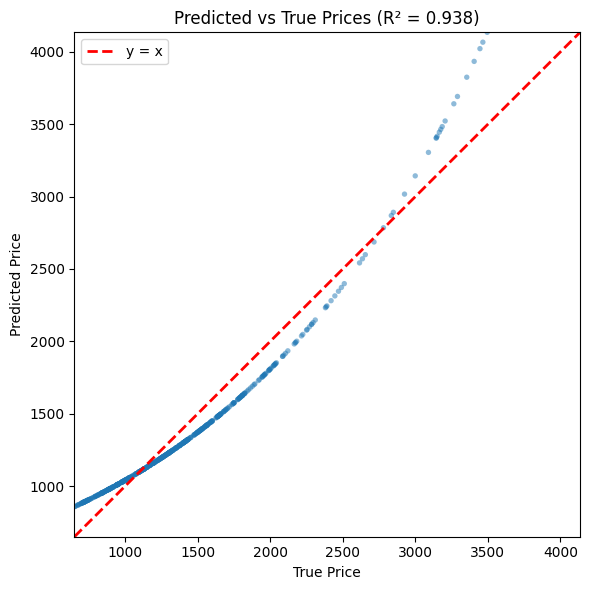

In [ ]:
# print best param
print("\nBest params:", grid.best_params_)
print(f"Best CV MSE (price units): {-grid.best_score_:.2f}")

# eval best on test
best_model = grid.best_estimator_

pred   = np.expm1(best_model.predict(Xte))
y_true = np.expm1(yte.to_numpy())

mse  = mean_squared_error(y_true, pred)
mae  = mean_absolute_error(y_true, pred)
r2   = r2_score(y_true, pred)

print(f"\nTest — MSE: {mse:.2f} |  MAE: {mae:.2f} | R²: {r2:.3f}")

# plot r2 on test
plt.figure(figsize=(6,6))
plt.scatter(y_true, pred, s=15, alpha=0.5, edgecolor="none")
lims = [min(np.min(y_true), np.min(pred)), max(np.max(y_true), np.max(pred))]
plt.plot(lims, lims, 'r--', lw=2, label='y = x')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('True Price'); plt.ylabel('Predicted Price')
plt.title(f'Predicted vs True Prices (R² = {r2:.3f})')
plt.legend(); plt.tight_layout(); plt.show()

### non-linear

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=None, # max depth of each tree; None = no explicit depth cap
    max_leaf_nodes=31,# cap on leaves per tree; more leaves = more flexible
    l2_regularization=0.0,# L2 penalty on leaf values; >0 shrinks/smooths predictions
    max_iter=200,
    random_state=42
)

gbr.fit(Xtr, ytr)
pred = np.expm1(gbr.predict(Xte))

y_true = np.expm1(yte.to_numpy())

mse  = mean_squared_error(y_true, pred)
print(f"HGBR MSE: {mse:.2f}")

HGBR MSE: 344.13


#### tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold

# use same cv, scorer as first model

# base
hgb = HistGradientBoostingRegressor(
    random_state=42, early_stopping=True, validation_fraction=0.1
)

# param grid
param_distributions = {
    "learning_rate": [0.02, 0.05, 0.1],
    "max_depth": [None, 3, 5, 7],
    "max_leaf_nodes": [15, 31, 63, ],
    "l2_regularization": [0.0, 1e-3, 1e-2, 1e-1],
}

# tune on train
search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_distributions,
    n_iter=40,
    scoring=mse_scorer,     # minimize MSE in price units
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=False
)
search.fit(Xtr, ytr)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                           random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'l2_regularization': [0.0, 0.001, 0.01,
                                                              0.1],
                                        'learning_rate': [0.02, 0.05, 0.1],
                                        'max_depth': [None, 3, 5, 7],
                                        'max_leaf_nodes': [15, 31, 63]},
                   random_state=42,
                   scoring=make_scorer(mse_price, greater_is_better=False, response_method='predict'))

##### print best

In [ ]:
# print best param
print("\nBest params:", search.best_params_)
print(f"Best CV MSE (price units): {-search.best_score_:.2f}")

# eval best on test
best_hgb = search.best_estimator_
pred   = np.expm1(best_hgb.predict(Xte))
y_true = np.expm1(yte.to_numpy())

mse = mean_squared_error(y_true, pred)
print(f"Test MSE: {mse:.2f}")


Best params: {'max_leaf_nodes': 31, 'max_depth': None, 'learning_rate': 0.1, 'l2_regularization': 0.01}
Best CV MSE (price units): 739.72
Test MSE: 666.60


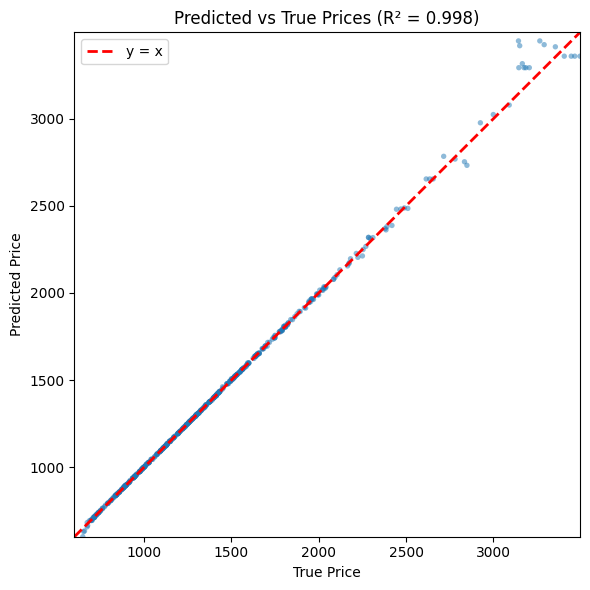

In [ ]:
r2 = r2_score(y_true, pred)
plt.figure(figsize=(6,6))
plt.scatter(y_true, pred, s=15, alpha=0.5, edgecolor="none")
lims = [min(np.min(y_true), np.min(pred)), max(np.max(y_true), np.max(pred))]
plt.plot(lims, lims, 'r--', lw=2, label='y = x')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('True Price'); plt.ylabel('Predicted Price')
plt.title(f'Predicted vs True Prices (R² = {r2:.3f})')
plt.legend(); plt.tight_layout(); plt.show()